In [1]:
import pandas as pd
import numpy as np
import sklearn
import imblearn

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

for i in [pd, np, sklearn, imblearn, mpl, sns]:
    print(i.__name__, i.__version__)

pandas 0.25.1
numpy 1.18.5
sklearn 0.21.3
imblearn 0.5.0
matplotlib 3.5.3
seaborn 0.12.2


# 3- 4. 클래스 불균형 해소(Class Imbalance)


- 클래스 불균형 문제는 한 클래스가 다른 클래스에 비해 훨씬 더 많거나 적은 경우를 말합니다.


- 클래스의 불균형으로 인한 성능 저하를 완화하기 위한 방법들을 알아봅니다.


- f1 점수(f1 score), 마이크로 재현율(micro recall)과 같이 소수의 클래스의 분류 정확도를 올리면 성능 향상을 기대할 수 있습니다. 클래스 불균형 해소를 통해 성능의 개선 효과를 기대할 수 있습니다.

> $\text{f1 점수(f1 score)} = 2 × \frac{Recall × Precision }{Recall + Precision}$
>
> $\text{마이크로 재현율(Macro recall)} = \frac{1}{c}\sum_{i=1}^c \text{Recall}_i$, $\text{Recall}_i$: i 클래스를 양성으로 했을 때의 재현율(Recall)



### Credit Card Fraud Detection

[신용 카드 사기 거래 탐지](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) 데이터 셋입니다.

|Name|Description|
|----|---------|
|Time|첫 거래와의 시간 차, 초(second)단위|
|V1, V2, ... V28|PCA를 통해 처리된 속성 데이터|
|amount|거래 금액|
|Class|1: Fraud, 0: Other|

284,807 건의 거래 중에서 492 건 만이 Fraud(사기 거래) 입니다. 

굉장히 치우침이 심한 데이터셋입니다.

In [2]:
df_credit = pd.read_pickle('data/credit.pkl')

df_credit.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359375,-0.072754,2.537109,1.377930,-0.338379,0.462402,0.239624,0.098694,0.363770,...,-0.018311,0.277832,-0.110474,0.066956,0.128540,-0.189087,0.133545,-0.021057,149.625000,0
1,0,1.191406,0.266113,0.166504,0.448242,0.060028,-0.082336,-0.078796,0.085083,-0.255371,...,-0.225830,-0.638672,0.101318,-0.339844,0.167114,0.125854,-0.008980,0.014725,2.689453,0
2,1,-1.358398,-1.339844,1.773438,0.379883,-0.503418,1.800781,0.791504,0.247681,-1.514648,...,0.248047,0.771484,0.909180,-0.689453,-0.327637,-0.139038,-0.055359,-0.059753,378.750000,0
3,1,-0.966309,-0.185181,1.792969,-0.863281,-0.010307,1.247070,0.237549,0.377441,-1.386719,...,-0.108276,0.005272,-0.190308,-1.175781,0.647461,-0.221924,0.062744,0.061462,123.500000,0
4,2,-1.158203,0.877930,1.548828,0.403076,-0.407227,0.095947,0.592773,-0.270508,0.817871,...,-0.009430,0.798340,-0.137451,0.141235,-0.206055,0.502441,0.219482,0.215210,70.000000,0


## 1. Over sampling

- 빈도가 상대적으로 적은 클래스 데이터를 더 생성하여 불균형을 해소하는 방법입니다.

### Random Over Sampling

샘플할 클래스와 동일한 클래스인 데이터 중에서 임의로 뽑아내는 샘플링 방법입니다.

**imblearn.over_sampling.RandomOverSampler**

 sampling_strategy: 
 
> float일 경우, 이진 분류에만 유효합니다. 리샘플링 후 $\frac{\text{소수 클래스의 샘플링 후의 개수}}{\text{다수 클래스의 개수}}$
>
> dict일 경우, {Class: 빈도수} 의 구조. 리샘플링 후의 각 클래스의 샘플 수
>
> 'minority': 가장 빈도가 적은 클래스만 리샘플링합니다.
> 
> 'not majority': 가장 빈도가 높은 클래스를 제외하고 리샘플링
> 
> 'auto': 자동 - not majority 

**[Ex.1]** 

클래스수가 2개인 클래스 불균형 지닌 데이터셋을 만들고,

samping_strategy 설정에 따라 추출된 데이터의 클래스의 개수를 확인하여 OverSampler의 동작을 확인합니다. 

```
[0.1, 0.5, 1.0, 'minority']
```

In [3]:
from sklearn.datasets import make_classification
X, y = make_classification(
    n_samples=5000, n_features=2, n_informative=2,
    n_redundant=0, n_repeated=0, n_classes=2,
    n_clusters_per_class=1,
    weights=[0.01, 0.99],
    class_sep=0.8, random_state=123
)

In [4]:
from imblearn.over_sampling import RandomOverSampler
class_cnt = [pd.Series(y).value_counts().rename('Original')]
for i in [0.1, 0.5, 1.0, 'minority']:
    ros = RandomOverSampler(sampling_strategy=i)
    X_ros, y_ros = ros.fit_resample(X, y)
    class_cnt.append(
        pd.Series(y_ros).value_counts().rename('Sampling strategy: {}'.format(i))
    )
pd.concat(class_cnt, axis=1)

,Original,Sampling strategy: 0.1,Sampling strategy: 0.5,Sampling strategy: 1.0,Sampling strategy: minority
1,4919,4919,4919,4919,4919
0,81,491,2459,4919,4919


**[Ex.2]** 

클래스수가 3개인 클래스 불균형 지닌 데이터셋을 만들고,

samping_strategy 설정에 따라 추출된 데이터의 클래스의 개수를 확인하여 OverSampler의 동작을 확인합니다. 


```
[{0: 100, 2: 200}, 'minority', 'not majority']
```

In [5]:
from sklearn.datasets import make_classification
X, y = make_classification(
    n_samples=5000, n_features=2, n_informative=2,
    n_redundant=0, n_repeated=0, n_classes=3,
    n_clusters_per_class=1,
    weights=[0.01, 0.99],
    class_sep=0.8, random_state=123
)

In [6]:
class_cnt = list([pd.Series(y).value_counts().rename('Original')])
for i in [{0: 100, 2: 200}, 'minority', 'not majority']:
    ros = RandomOverSampler(sampling_strategy=i)
    X_ros, y_ros = ros.fit_resample(X, y)
    class_cnt.append(
        pd.Series(y_ros).value_counts().rename('Sampling strategy: {}'.format(i))
    )
pd.concat(class_cnt, axis=1)

,Original,"Sampling strategy: {0: 100, 2: 200}",Sampling strategy: minority,Sampling strategy: not majority
0,64,100,64,4914
1,4914,4914,4914,4914
2,22,200,4914,4914


이후 클래스 불균형 처리 방법에서 예시를 들기 위한 데이터 처리 작업입니다.

df_fraud 데이터셋의 타겟 변수인 Class의 비율을 동일하게 하여,

80%는 학습데이터 df_train으로, 20%는 평가데이터 df_test로 나눕니다.

Class가 1인 경우가 양성(Positive)이고 0이 음성(Negative) 입니다.

In [7]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_credit, train_size=0.8, random_state=123, stratify=df_credit['Class'])

In [8]:
df_train['Class'].value_counts(normalize=True)

0    0.998271
1    0.001729
Name: Class, dtype: float64

**[Ex.3]**

학습 데이터 df_train에서 대상 변수(Class)를 제외한 모든 변수를 입력 변수로 설정합니다. 

Class가 양성(Positive)인 비율을 아래와 같이 변화를 주어 df_train을 Random Over Sampling을 수행하면서, 

성능의 차이를 살펴 봅니다.

Over Sampling한 df_train으로 학습하고, df_test로 성능을 측정합니다.

성능 지표는 f1-score 이고, 학습 모델은 로지스틱 회귀(Logistic Regression)입니다.


```
postive_ratio = [0.005, 0.01, 0.015, 0.02, 0.03, 0.05, 0.08, 0.1, 0.15]
```

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score

f1_train_ros, f1_test_ros = list(), list()
acc_train, acc_test = list(), list()
X_cols = [i for i in df_train.columns if i !='Class']
# 표준화 처리기와 로지스틱 회귀모델을 결합합니다.
clf_lr = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs'))
clf_lr.fit(df_train[X_cols], df_train['Class'])

# 오버샘플링하지 않았을 경우의 성능을 기록합니다.
prd = clf_lr.predict(df_train[X_cols])
f1_train_ros.append(f1_score(df_train['Class'], prd))
acc_train.append(accuracy_score(df_train['Class'], prd))
prd = clf_lr.predict(df_test[X_cols])
f1_test_ros.append(f1_score(df_test['Class'], prd))
acc_test.append(accuracy_score(df_test['Class'], prd))

# 제시한 오버샘플링 비율에 따른 성능을 측정합니다.
postive_ratio = [0.005, 0.01, 0.015, 0.02, 0.03, 0.05, 0.08, 0.1, 0.15]
for i in postive_ratio:
    ros = RandomOverSampler(sampling_strategy=i)
    X_ros, y_ros = ros.fit_resample(df_train[X_cols], df_train['Class'])
    clf_lr = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs'))
    clf_lr.fit(X_ros, y_ros)
    prd = clf_lr.predict(X_ros)
    f1_train_ros.append(f1_score(y_ros, prd))
    acc_train.append(accuracy_score(y_ros, prd))
    prd = clf_lr.predict(df_test[X_cols].values)
    f1_test_ros.append(f1_score(df_test['Class'], prd))
    acc_test.append(accuracy_score(df_test['Class'], prd))
postive_ratio = [df_train['Class'].value_counts(normalize=True).loc[1]] + postive_ratio

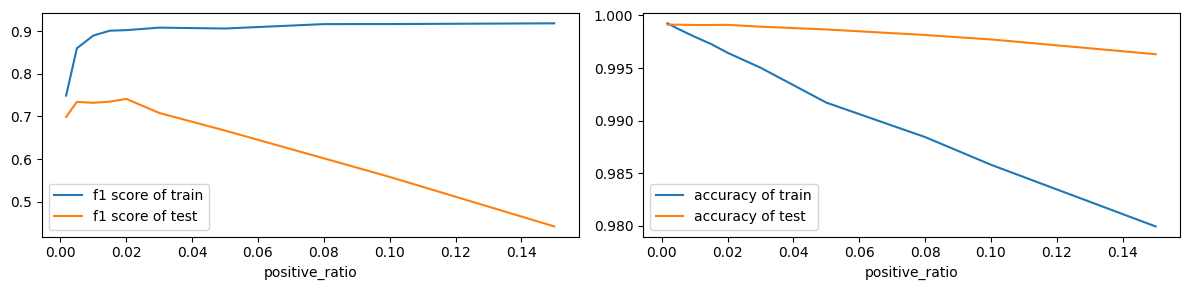

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
axes[0].plot(postive_ratio, f1_train_ros, label='f1 score of train')
axes[0].plot(postive_ratio, f1_test_ros, label='f1 score of test')
axes[0].set_xlabel('positive_ratio')
axes[0].legend()

axes[1].plot(postive_ratio, acc_train, label='accuracy of train')
axes[1].plot(postive_ratio, acc_test, label='accuracy of test')
axes[1].set_xlabel('positive_ratio')
axes[1].legend()

plt.tight_layout()
plt.show()

### SMOTE(Synthetic Minor Over-Sampling Technique)

샘플링 클래스에 해당하는 데이터 포인트를 임의로 선택한 후,

선택한 데이터와 동일 클래스인 k개의 최근접 이웃 데이터 포인트를 구합니다.

k개의 이웃 중 하나를 골라 두 데이터 포인트간 직선 위의 하나의 포인트를 샘플링합니다. 

#### 알고리즘

1. 샘플링 대상 클래스에 해당하는 데이터 포인트를 임의로 선정하고, k개의 동일 클래스인 최근접 이웃 구합니다. 


2. 이웃 중에 무작위로 하나를 선택하고, 두 데이터 포인트를 잇는 직선상의 임의 포인트를 표본으로 만듭니다.


3. 원하는 수만큼의 표본을 취할 때까지 1부터 반복합니다.


**imblearn.over_sampling import SMOTE**

**주요 하이파라메터**

|이름|설명|
|---|:-----|
|k_neighbors|주변 샘플 수|

**[Ex.3]**

SMOTE 알고리즘이 동작하기 위해 2차원의 클래스가 불균형한 2진 데이터를 만듭니다.

SMOTE 후의 표본이 만들어지는 형태를 확인하여 SMOTE의 표본 생성 메카니즘을 시각화해봅니다.

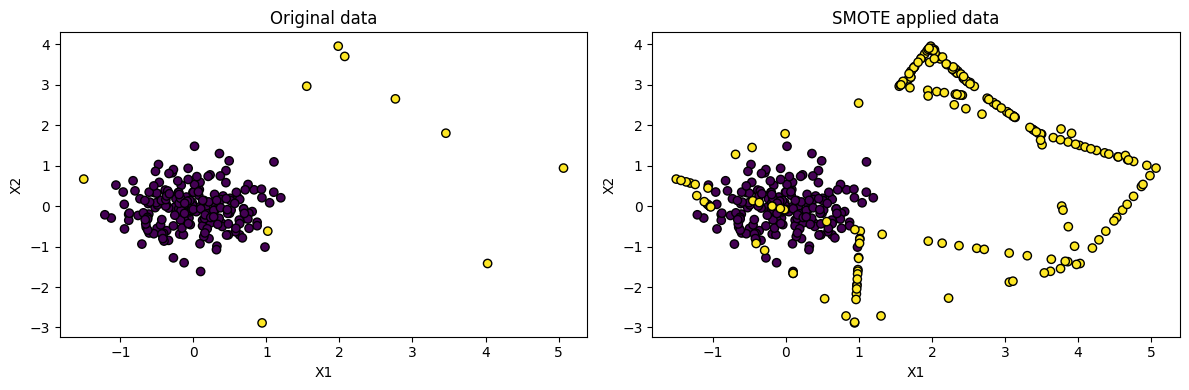

In [11]:
from sklearn.datasets import make_blobs
from imblearn.over_sampling import SMOTE

# 2차원 데이터 샘플 생성
X, y = make_blobs(n_samples=[200, 10], centers=[[0, 0], [2, 2]], cluster_std=[0.5, 2], random_state=123)
# SMOTE 적용
smote = SMOTE(sampling_strategy='not majority', k_neighbors=3, random_state=123)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 원본 데이터 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for X_, y_, ax, title in zip([X, X_resampled], [y, y_resampled], axes, ['Original data', 'SMOTE applied data']):
    ax.scatter(X_[:, 0], X_[:, 1], c=y_, marker='o', edgecolors='k')
    ax.set_title(title)
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')

plt.tight_layout()
plt.show()

**[Ex.4]**

학습 데이터 df_train에서 대상 변수 Class를 제외한 모든 변수를 입력 변수로 설정합니다. 

Class가 양성(Positive)인 비율을 아래와 같이 변화를 주어, 

df_train을 SMOTE 알고리즘으로 Over Sampling하고 성능의 차이를 살펴 봅니다.

df_train을 Over Sampling한 데이터로 학습하고, df_test로 성능을 측정합니다.

성능 지표는 f1-score 이고, 학습 모델은 로지스틱 회귀(Logistic Regression)입니다.


```
postive_ratio = [0.005, 0.01, 0.015, 0.02, 0.03, 0.05, 0.08, 0.1, 0.15]
```

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score

f1_train_smote, f1_test_smote = list(), list()
acc_train, acc_test = list(), list()
X_cols = [i for i in df_train.columns if i !='Class']
# 표준화 처리기와 로지스틱 회귀모델을 결합합니다.
clf_lr = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs'))
clf_lr.fit(df_train[X_cols], df_train['Class'])

# SMOTE처리를 하지 않았을 경우의 성능을 기록합니다.
prd = clf_lr.predict(df_train[X_cols])
f1_train_smote.append(f1_score(df_train['Class'], prd))
acc_train.append(accuracy_score(df_train['Class'], prd))
prd = clf_lr.predict(df_test[X_cols])
f1_test_smote.append(f1_score(df_test['Class'], prd))
acc_test.append(accuracy_score(df_test['Class'], prd))

# 제시한 오버샘플링 비율에 따른 성능을 측정합니다.
postive_ratio = [0.005, 0.01, 0.015, 0.02, 0.03, 0.05, 0.08, 0.1, 0.15]
for i in postive_ratio:
    ros = SMOTE(sampling_strategy=i)
    X_ros, y_ros = ros.fit_resample(df_train[X_cols], df_train['Class'])
    clf_lr = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs'))
    clf_lr.fit(X_ros, y_ros)
    prd = clf_lr.predict(X_ros)
    f1_train_smote.append(f1_score(y_ros, prd))
    acc_train.append(accuracy_score(y_ros, prd))
    prd = clf_lr.predict(df_test[X_cols].values)
    f1_test_smote.append(f1_score(df_test['Class'], prd))
    acc_test.append(accuracy_score(df_test['Class'], prd))
postive_ratio = [df_train['Class'].value_counts(normalize=True).loc[1]] + postive_ratio

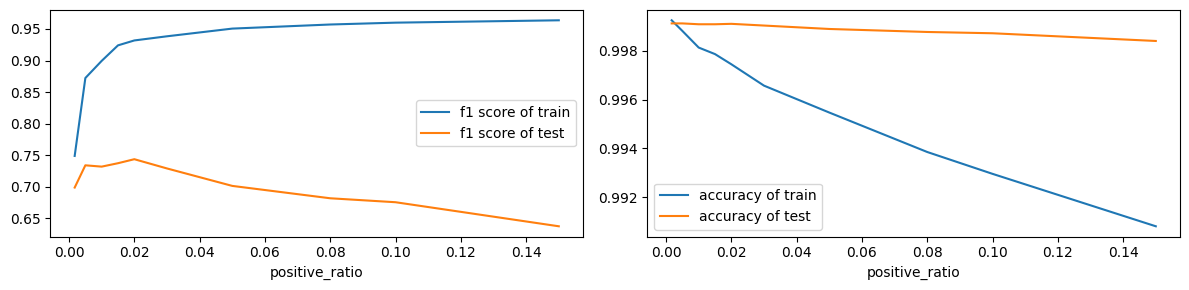

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
axes[0].plot(postive_ratio, f1_train_smote, label='f1 score of train')
axes[0].plot(postive_ratio, f1_test_smote, label='f1 score of test')
axes[0].set_xlabel('positive_ratio')
axes[0].legend()

axes[1].plot(postive_ratio, acc_train, label='accuracy of train')
axes[1].plot(postive_ratio, acc_test, label='accuracy of test')
axes[1].set_xlabel('positive_ratio')
axes[1].legend()

plt.tight_layout()
plt.show()

### ADASYN(Adaptive Synthetic Sampling)

SMOTE 기법을 보완하여 개발된 알고리즘입니다. 

샘플을 생성하는 수를 샘플 간 거리에 비례하도록 하여 밀도가 낮은 구역에 샘플이 더 확보되도록 합니다.

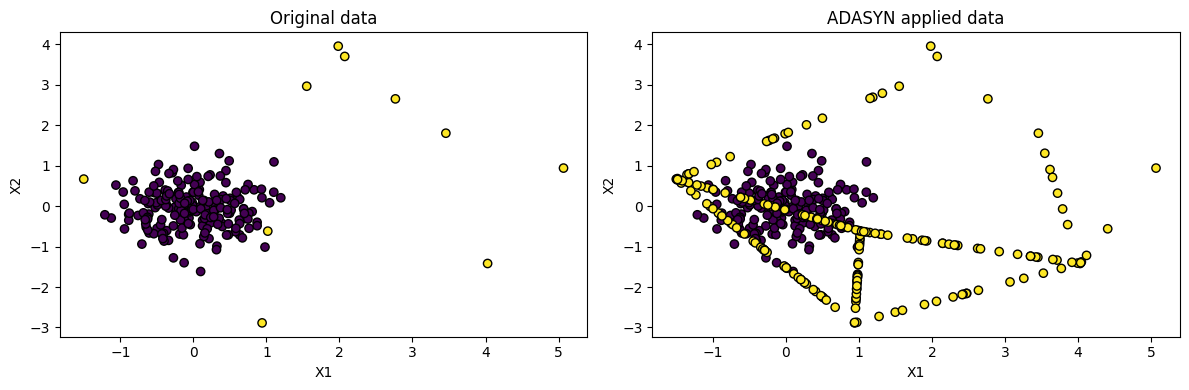

In [14]:
from sklearn.datasets import make_blobs
from imblearn.over_sampling import ADASYN

# 2차원 데이터 샘플 생성
X, y = make_blobs(n_samples=[200, 10], centers=[[0, 0], [2, 2]], cluster_std=[0.5, 2], random_state=123)
# SMOTE 적용
smote = ADASYN(sampling_strategy='not majority', n_neighbors=3, random_state=123)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 원본 데이터 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for X_, y_, ax, title in zip([X, X_resampled], [y, y_resampled], axes, ['Original data', 'ADASYN applied data']):
    ax.scatter(X_[:, 0], X_[:, 1], c=y_, marker='o', edgecolors='k')
    ax.set_title(title)
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')

plt.tight_layout()
plt.show()

**[Ex.5]**

학습 데이터 df_train에서 대상 변수 Class를 제외한 모든 변수를 입력 변수로 설정합니다. 

Class가 양성(Positive)인 비율을 아래와 같이 변화를 주어 df_train을 ADASYN 알고리즘으로 

Over Sampling하고 성능의 차이를 살펴 봅니다.

Over Sampling한 데이터로 학습을하고, df_test로 성능을 측정합니다.

성능 지표는 f1-score 이고, 학습 모델은 로지스틱 회귀(Logistic Regression)입니다.


```
postive_ratio = [0.005, 0.01, 0.015, 0.02, 0.03, 0.05, 0.08, 0.1, 0.15]
```

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score

f1_train_adasyn, f1_test_adasyn = list(), list()
acc_train, acc_test = list(), list()
X_cols = [i for i in df_train.columns if i !='Class']
clf_lr = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs'))
clf_lr.fit(df_train[X_cols], df_train['Class'])

prd = clf_lr.predict(df_train[X_cols])
f1_train_adasyn.append(f1_score(df_train['Class'], prd))
acc_train.append(accuracy_score(df_train['Class'], prd))
prd = clf_lr.predict(df_test[X_cols])
f1_test_adasyn.append(f1_score(df_test['Class'], prd))
acc_test.append(accuracy_score(df_test['Class'], prd))
postive_ratio = [0.005, 0.01, 0.015, 0.02, 0.03, 0.05, 0.08, 0.1, 0.15]
for i in postive_ratio:
    ros = ADASYN(sampling_strategy=i)
    X_ros, y_ros = ros.fit_resample(df_train[X_cols], df_train['Class'])
    clf_lr = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs'))
    clf_lr.fit(X_ros, y_ros)
    prd = clf_lr.predict(X_ros)
    f1_train_adasyn.append(f1_score(y_ros, prd))
    acc_train.append(accuracy_score(y_ros, prd))
    prd = clf_lr.predict(df_test[X_cols].values)
    f1_test_adasyn.append(f1_score(df_test['Class'], prd))
    acc_test.append(accuracy_score(df_test['Class'], prd))
postive_ratio = [df_train['Class'].value_counts(normalize=True).loc[1]] + postive_ratio

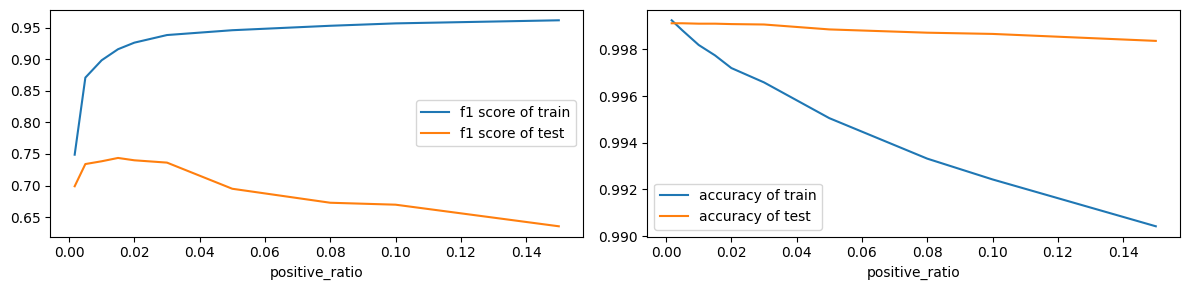

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
axes[0].plot(postive_ratio, f1_train_adasyn, label='f1 score of train')
axes[0].plot(postive_ratio, f1_test_adasyn, label='f1 score of test')
axes[0].set_xlabel('positive_ratio')
axes[0].legend()

axes[1].plot(postive_ratio, acc_train, label='accuracy of train')
axes[1].plot(postive_ratio, acc_test, label='accuracy of test')
axes[1].set_xlabel('positive_ratio')
axes[1].legend()

plt.tight_layout()
plt.show()

### 오버 샘플링의 장단점

#### 장점

- 정보 보존: 소수 클래스의 샘플을 합성하거나 복제하여 데이터의 소수 클래스의 데이터의 특성이 드러나게 하여 정보의 보존 효과를 줍니다.

#### 단점

- 소수 클래스의 샘플을 과도하게 증가시키면 과적합을 유발시킬 수 있습니다.


- 샘플이 증가함에 따라 학습시 계산 비용이 증가합니다.

## 2. Under sampling

- 다수 클래스(Major class)의 데이터를 줄여 불균형을 해소하는 방법입니다.



### Random Under Sampling

샘플링 클래스의 데이터를 임의로 선정하여 대상에서 제외시키는 샘플링 방법입니다.

**imblearn.under_sampling.RandomUnderSampling**

 sampling_strategy: 
 
> float일 경우, 이진 분류에만 유효합니다. 리샘플링 후 $\frac{\text{소수 클래스의 개수}}{\text{다수 클래스의 샘플링 후의 개수}}$
>
> dict일 경우, {Class: 빈도수} 의 구조. 리샘플링 후의 각 클래스의 샘플 수
>
> 'majority': 가장 빈도가 높은 클래스만 리샘플링합니다.
> 
> 'not minority': 가장 빈도가 적은 클래스를 제외하고 리샘플링
> 
> 'auto': 자동 - not majority 

**[Ex.6]** 

클래스수가 2개인 클래스 불균형 지닌  임의의 데이터셋을 만들고,

samping_strategy 설정에 따라 추출된 데이터의 클래스의 개수를 확인하여 UnderSampler의 동작을 확인합니다. 


```
[0.1, 0.5, 1.0, 'majority']
```

In [17]:
from sklearn.datasets import make_classification
X, y = make_classification(
    n_samples=5000, n_features=2, n_informative=2,
    n_redundant=0, n_repeated=0, n_classes=2,
    n_clusters_per_class=1,
    weights=[0.01, 0.99],
    class_sep=0.8, random_state=123
)

In [18]:
from imblearn.under_sampling import RandomUnderSampler
class_cnt = [pd.Series(y).value_counts().rename('Original')]
for i in [0.1, 0.5, 1.0, 'majority']:
    rus = RandomUnderSampler(sampling_strategy=i)
    X_rus, y_rus = rus.fit_resample(X, y)
    class_cnt.append(
        pd.Series(y_rus).value_counts().rename('Sampling strategy: {}'.format(i))
    )
pd.concat(class_cnt, axis=1)

,Original,Sampling strategy: 0.1,Sampling strategy: 0.5,Sampling strategy: 1.0,Sampling strategy: majority
1,4919,810,162,81,81
0,81,81,81,81,81


**[Ex.7]** 

클래스수가 3개인 클래스 불균형 지닌 임의의 데이터셋을 만들고,

samping_strategy 설정에 따라 추출된 데이터의 클래스의 개수를 확인하여 OverSampler의 동작을 확인합니다. 


```
[{0: 100, 1: 1000}, 'majority', 'not minority']
```

In [19]:
from sklearn.datasets import make_classification
X, y = make_classification(
    n_samples=5000, n_features=2, n_informative=2,
    n_redundant=0, n_repeated=0, n_classes=3,
    n_clusters_per_class=1,
    weights=[0.05, 0.95],
    class_sep=0.8, random_state=123
)

In [20]:
class_cnt = list([pd.Series(y).value_counts().rename('Original')])
class_cnt

[1    4715
 0     263
 2      22
 Name: Original, dtype: int64]

In [21]:
class_cnt = list([pd.Series(y).value_counts().rename('Original')])
for i in [{0: 100, 1: 1000}, 'majority', 'not minority']:
    rus = RandomUnderSampler(sampling_strategy=i)
    X_rus, y_rus = rus.fit_resample(X, y)
    class_cnt.append(
        pd.Series(y_rus).value_counts().rename('Sampling strategy: {}'.format(i))
    )
pd.concat(class_cnt, axis=1)

,Original,"Sampling strategy: {0: 100, 1: 1000}",Sampling strategy: majority,Sampling strategy: not minority
0,263,100,263,22
1,4715,1000,22,22
2,22,22,22,22


**[Ex.7]**

학습 데이터 df_train에서 대상 변수 Class를 제외한 모든 변수를 입력 변수로 설정합니다. 

Class가 양성(Positive)인 비율을 아래와 같이 변화를 주어 df_train을 Random Under Sampling방법으로 샘플하고 성능의 차이를 살펴 봅니다.

샘플링 데이터로 학습하고, df_test로 성능을 측정합니다.

성능 지표는 f1-score 이고, 학습 모델은 로지스틱 회귀(Logistic Regression)입니다.


```
negative_ratio = [0.005, 0.01, 0.015, 0.02, 0.03, 0.05, 0.08, 0.1, 0.15]
```

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score

f1_train_rus, f1_test_rus = list(), list()
acc_train, acc_test = list(), list()
X_cols = [i for i in df_train.columns if i !='Class']

# 표준화 처리기와 로지스틱 회귀모델을 결합합니다.
clf_lr = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs'))
clf_lr.fit(df_train[X_cols], df_train['Class'])

# 언더샘플링하지 않았을 경우의 성능을 기록합니다.
prd = clf_lr.predict(df_train[X_cols])
f1_train_rus.append(f1_score(df_train['Class'], prd))
acc_train.append(accuracy_score(df_train['Class'], prd))
prd = clf_lr.predict(df_test[X_cols])
f1_test_rus.append(f1_score(df_test['Class'], prd))
acc_test.append(accuracy_score(df_test['Class'], prd))

# 설정에 따른 성능을 측정하여 기록합니다.
negative_ratio = [0.005, 0.01, 0.015, 0.02, 0.03, 0.05, 0.08, 0.1, 0.15]
for i in negative_ratio:
    rus = RandomUnderSampler(sampling_strategy=i, random_state=123)
    X_rus, y_rus = rus.fit_resample(df_train[X_cols], df_train['Class'])
    clf_lr = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs'))
    clf_lr.fit(X_rus, y_rus)
    prd = clf_lr.predict(X_rus)
    f1_train_rus.append(f1_score(y_rus, prd))
    acc_train.append(accuracy_score(y_rus, prd))
    prd = clf_lr.predict(df_test[X_cols].values)
    f1_test_rus.append(f1_score(df_test['Class'], prd))
    acc_test.append(accuracy_score(df_test['Class'], prd))
negative_ratio =  [df_train['Class'].value_counts(normalize=True).loc[1]] + negative_ratio

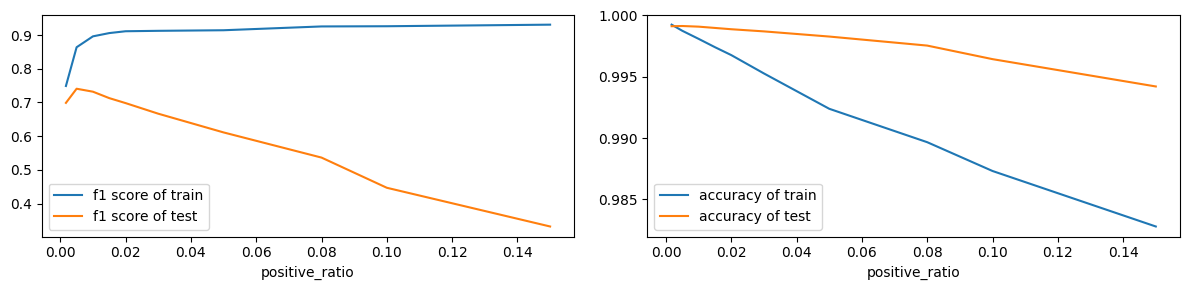

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
axes[0].plot(negative_ratio, f1_train_rus, label='f1 score of train')
axes[0].plot(negative_ratio, f1_test_rus, label='f1 score of test')
axes[0].set_xlabel('positive_ratio')
axes[0].legend()

axes[1].plot(negative_ratio, acc_train, label='accuracy of train')
axes[1].plot(negative_ratio, acc_test, label='accuracy of test')
axes[1].set_xlabel('positive_ratio')
axes[1].legend()

plt.tight_layout()
plt.show()

### Tomek's Link 알고리즘

#### Tomek's Link

서로 다른 클래스에 속하는 두 점의 거리가 두 점에서의 가장 가까운 경우를 Tomek's Link라고 합니다.

Tomek's Link는 결정 경계면과 가깝게 위치하여 클래스 분류에 혼동을 일으킬 가능성이 높습니다.

Tomek's Link 중에서 둘 중에 하나의 클래스가 언더 샘플림 대상 클래스면 데이터셋에서 제외 시킵니다.

**[Ex.8]**

Tomek's Link 방법을 확인해 보고자, 3개 클래스를 지닌 클래스 불균형 문제를 지닌 2차원 데이터셋을 만듭니다. 

Tomek's Link를 직접 구해 보고, 결과를 시각화해 봅니다.

In [24]:
from sklearn.datasets import make_blobs

# 2차원 데이터 샘플 생성
X, y = make_blobs(
    n_samples=[150, 50, 30], 
    centers=[[-0.5, 0], [2, 2], [1.5, -1]], 
    cluster_std=[0.5, 1.0, 0.7], random_state=123
)

df_tomek = pd.DataFrame(X, columns=['X1', 'X2']).assign(y = y.astype('str'))

In [25]:
from scipy.spatial.distance import pdist,squareform
X_cols = ['X1', 'X2']
majority_class = df_tomek['y'].value_counts().idxmax()
# 최근접점을 구하기 위해 데이터 포인트간 거리를 구합니다.
df_dist = pd.DataFrame(
    squareform(pdist(df_tomek[X_cols])), 
    index = df_tomek.index, 
    columns = df_tomek.index
)
# 데이터 포인트에서 자기자신을 제외한 최근접점의 인덱스를 구합니다.
s_idx_nearest = df_dist.apply(lambda x: x.loc[x.index != x.name].idxmin(), axis=1)
tomek_links_index = s_idx_nearest.loc[
    (df_tomek['y'] == majority_class) & # 다수 클래스 인지 확인
    (df_tomek['y'] != s_idx_nearest.map(df_tomek['y'])) & # 서로가 다른 클래스인지 확인
    s_idx_nearest.map(s_idx_nearest).pipe(lambda x: x.index == x) # 서로가 최근접점인지 확인
].index.values
tomek_links_index

array([  1,   4, 104, 186, 194], dtype=int64)

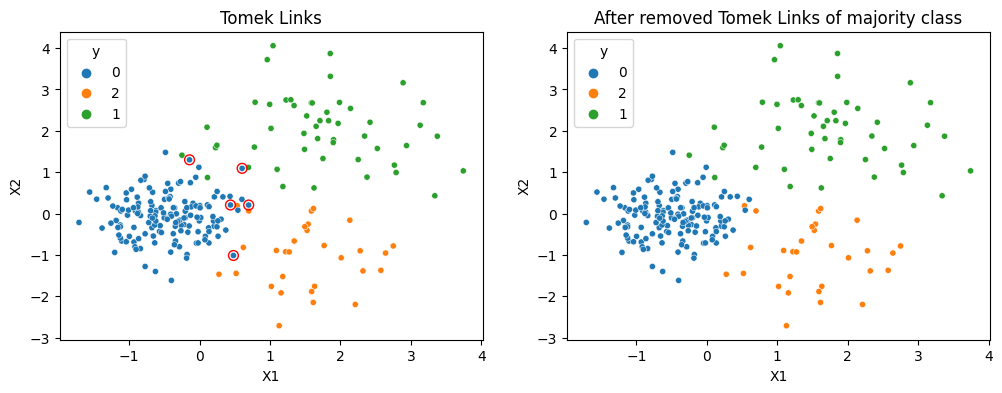

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.scatterplot(data=df_tomek, x='X1', y='X2', hue='y', s=20, ax=axes[0])
axes[0].set_title('Tomek Links')
axes[0].set_xlabel('X1')
axes[0].set_ylabel('X2')

axes[0].scatter(
    x = df_tomek.loc[tomek_links_index, 'X1'],
    y = df_tomek.loc[tomek_links_index, 'X2'],
    s = 50, color='r', facecolors='none'
)
    
sns.scatterplot(
    data=df_tomek.loc[~df_tomek.index.isin(tomek_links_index)], 
    x='X1', y='X2', hue='y', s=20, ax=axes[1]
)
axes[1].set_title('After removed Tomek Links of majority class')
axes[1].set_xlabel('X1')
axes[1].set_ylabel('X2')
plt.show()

**imblearn.under_sampling.TomekLinks**

TomekLinks는 TomekLink의 수에 따라 샘플링 데이터 수가 정해지므로 임의의 개수로 표본 수를 만든는 것은 지원하지 않습니다.

어떤 클래스를 TomekLink로 지정할 지를 설정합니다. 

 sampling_strategy: 
 
>
> 'majority': 가장 빈도가 높은 클래스만 리샘플링합니다.
> 
> 'not minority': 가장 빈도가 낮은 클래스를 제외하고 리샘플링
>
> 'not majority': 가장 빈도가 높은 클래스를 제외하고 리샘플링
>
> 'auto': 자동 - not minority 

In [27]:
from imblearn.under_sampling import TomekLinks

tomek = TomekLinks(sampling_strategy='majority')
X_tomek, y_tomek = tomek.fit_resample(df_tomek[X_cols], df_tomek['y'])

**[Ex.9]**

학습 데이터 df_train에서 대상 변수 Class를 제외한 모든 변수를 입력 변수로 설정합니다. 

Class가 양성(Positive)인 비율을 Tomek's Link 알고리즘으로 Under sampling 합니다. 

샘플링 데이터로 학습하고, df_test로 성능을 측정합니다.

성능 지표는 f1-score 이고, 학습 모델은 로지스틱 회귀(Logistic Regression)입니다.


In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score

f1_train_tomek, f1_test_tomek = list(), list()
acc_train, acc_test = list(), list()
X_cols = [i for i in df_train.columns if i !='Class']
clf_lr = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs'))
clf_lr.fit(df_train[X_cols], df_train['Class'])

rus = TomekLinks(sampling_strategy='majority')
X_tomek, y_tomek = rus.fit_resample(df_train[X_cols], df_train['Class'])
clf_lr = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs'))
clf_lr.fit(X_tomek, y_tomek)
prd = clf_lr.predict(X_tomek)
f1_train_tomek.append(f1_score(y_tomek, prd))
acc_train.append(accuracy_score(y_tomek, prd))
prd = clf_lr.predict(df_test[X_cols].values)
f1_test_tomek.append(f1_score(df_test['Class'], prd))
acc_test.append(accuracy_score(df_test['Class'], prd))
negative_ratio =  [df_train['Class'].value_counts(normalize=True).loc[1]] + negative_ratio

In [29]:
f1_train_tomek, f1_test_tomek

([0.7478005865102639], [0.6987951807228915])

### 언더 샘플링의 장단점

#### 장점

- 데이터셋의 크기를 줄이기 때문에 모델 학습이 더 빠르게 진행될 수 있습니다.


- 잡음 감소: 다수 클래스의 샘플을 제거함으로써 데이터셋의 잡음감소 효과를 얻을 수 있습니다.
    
#### 단점

- 정보 손실: 다수 클래스의 샘플을 제거하면 데이터의 다양성이 감소할 수 있습니다. 
 

- 소수 클래스의 대표성 손실: 중요한 소수 클래스의 정보가 대조군이 되는 다수 클래스의 표본이 사라짐에 따라 정보가 손실이 될 수 있습니다.
    

In [30]:
np.max(f1_test_ros), np.max(f1_test_smote), np.max(f1_test_adasyn), np.max(f1_test_rus), np.max(f1_test_tomek)

(0.7411167512690355,
 0.743718592964824,
 0.743718592964824,
 0.7407407407407408,
 0.6987951807228915)

## 3. 클래스 분류 임계점 조정

클래스를 분류하는 성능 지표를 최대화하는 임계점을 찾는 방법입니다.


**[Ex.10]**

학습 데이터 df_train에서 대상 변수 Class를 제외한 모든 변수를 입력 변수로 설정합니다. 

df_train으로 로지스틱 회귀 모델을 학습시킵니다. 

양성으로 분류를 다음과 같이 정합니다.

> $P(Class = True) > \alpha$, $P(Class = True)$는 양성으로 예측한 확률입니다.

df_train의 각 데이터의 양성일 확률 구하고, $\alpha$를 0.01 에서 0.99 까지의 101개의 균등한 구간으로 나눈 수 중에서

가장 좋은 f1 score를 보인 $\alpha$를 찾습니다.

df_test의 예측 확률을 구해 이 $\alpha$로 양성 클래스를 분류하여 f1 score르 측정해봅니다.

성능 지표는 f1-score 입니다.

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score

f1_train_tomek, f1_test_tomek = list(), list()
acc_train, acc_test = list(), list()
X_cols = [i for i in df_train.columns if i !='Class']
clf_lr = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs'))
clf_lr.fit(df_train[X_cols], df_train['Class'])

prob = clf_lr.predict_proba(df_train[X_cols])[:, 1]

In [32]:
thresholds = np.linspace(0.01, 0.99, 101)
f1_scores = [f1_score(df_train['Class'], prob >= threshold )for threshold in thresholds]
idx_max = np.argmax(f1_scores)
f1_scores[idx_max], thresholds[idx_max]

(0.80970625798212, 0.11779999999999999)

In [33]:
prob_test = clf_lr.predict_proba(df_test[X_cols])[:, 1]
f1_score(df_test['Class'], prob_test >= thresholds[idx_max])

0.7434554973821991

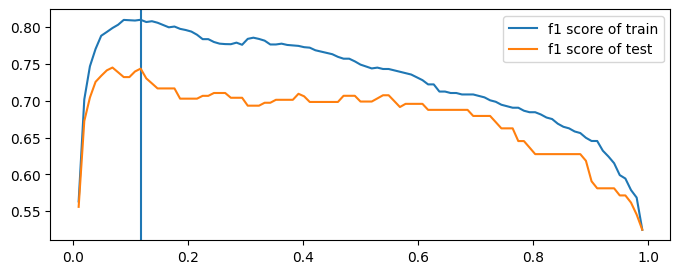

In [34]:
plt.figure(figsize=(8, 3))
plt.plot(thresholds, f1_scores, label='f1 score of train')
plt.axvline(thresholds[idx_max])
plt.plot(thresholds, [f1_score(df_test['Class'], prob_test >= threshold) for threshold in thresholds], label='f1 score of test')
plt.legend()
plt.show()

## 4. 데이터 가중치 차등 부여

학습시 클래스의 비중을 성능을 최대화 하는 방향으로 조정합니다.

※ sklearn에서는 클래스별 가중치를 조정하는 기능을 제공합니다.

**[Ex.9]**


학습 데이터 df_train에서 대상 변수 Class를 제외한 모든 변수를 입력 변수로 설정합니다. 

df_train으로 로지스틱 회귀 모델을 클래스 가중치를 다음과 같이 바꾸어 가면서 학습합니다. 

음의 클래스의 가중치를 1로 고정하고, 양의 클래스의 가중치를 1에서 10까지 0.5씩 증가시켜가면서 

학습을 시키고 f1 score를 측정합니다. 

가장 좋은 f1 score를 보인 경우를 확인해봅니다. 

가중치별 학습데이터의 성능과 평가데이터의 성능 추이를 확인해봅니다.

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score

f1_train_weight, f1_test_weight = list(), list()
X_cols = [i for i in df_train.columns if i !='Class']
weights = np.arange(1, 10.5, 0.5)
f1_scores = list()
    
for i in weights:
    clf_lr = make_pipeline(
        StandardScaler(), 
        LogisticRegression(solver='lbfgs', class_weight={0: 1.0, 1: i})
    )
    clf_lr.fit(df_train[X_cols], df_train['Class'])
    prd = clf_lr.predict(df_train[X_cols].values)
    f1_train_weight.append(f1_score(df_train['Class'], prd))
    prd = clf_lr.predict(df_test[X_cols].values)
    f1_test_weight.append(f1_score(df_test['Class'], prd))

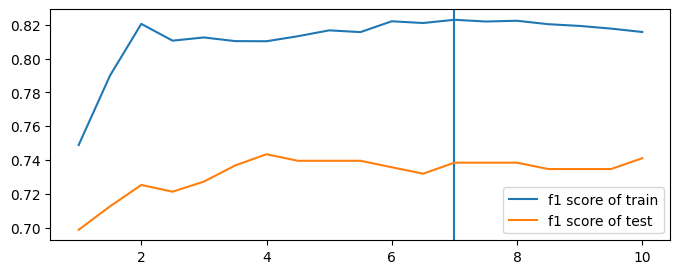

In [36]:
plt.figure(figsize=(8, 3))
plt.plot(weights, f1_train_weight, label='f1 score of train')
plt.axvline(weights[np.argmax(f1_train_weight)])
plt.plot(weights, f1_test_weight, label='f1 score of test')
plt.legend()
plt.show()

In [37]:
f1_test_weight[np.argmax(f1_train_weight)]

0.7384615384615386